In [22]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

In [20]:
#seeds:
np.random.seed(123)
tf.random.set_seed(123)

# Data Loading

In [9]:
df = pd.read_csv('./Data/artists.csv', sep=",")
print("The number of painting is {}.".format(df.shape[0]))

The number of painting is 50.


In [10]:
df.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


# Data Visualization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


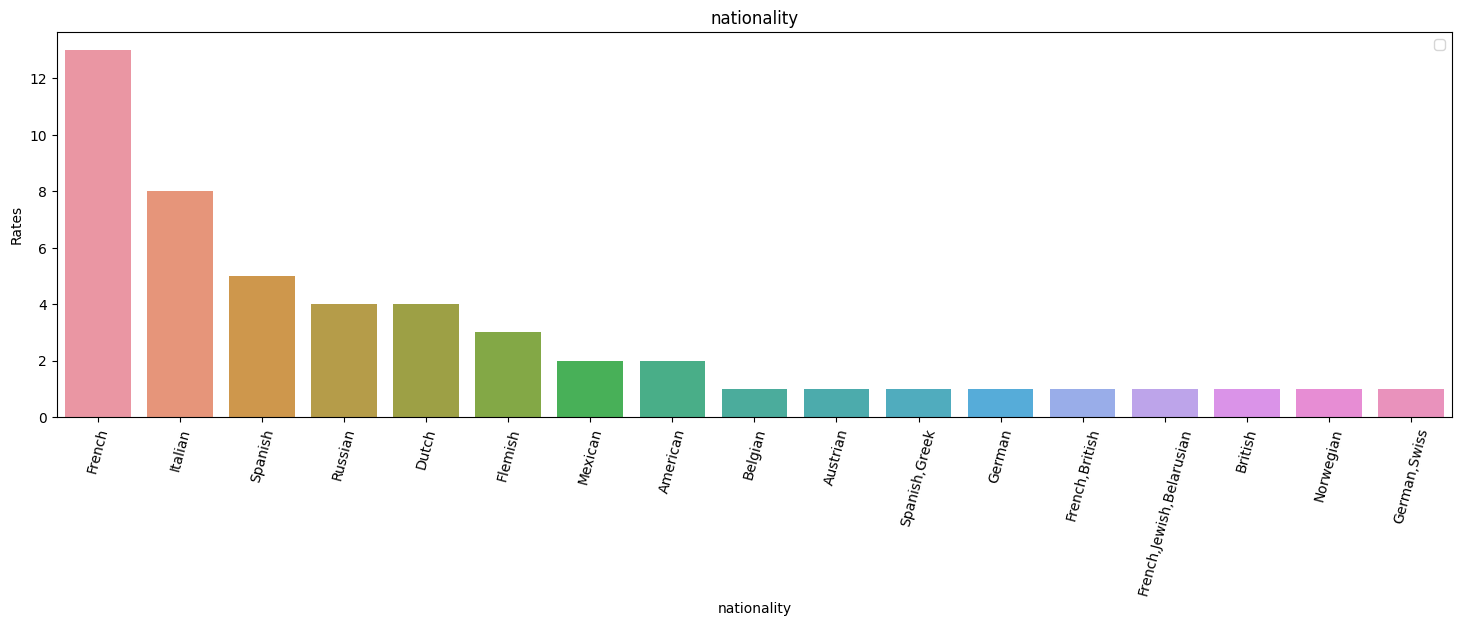

In [11]:
plt.figure(figsize=(18,5))

sns.barplot(x=df['nationality'].value_counts().index,y=df['nationality'].value_counts().values)
plt.title('nationality')
plt.xticks(rotation=75)
plt.ylabel('Rates')
plt.legend(loc=0)
plt.show()

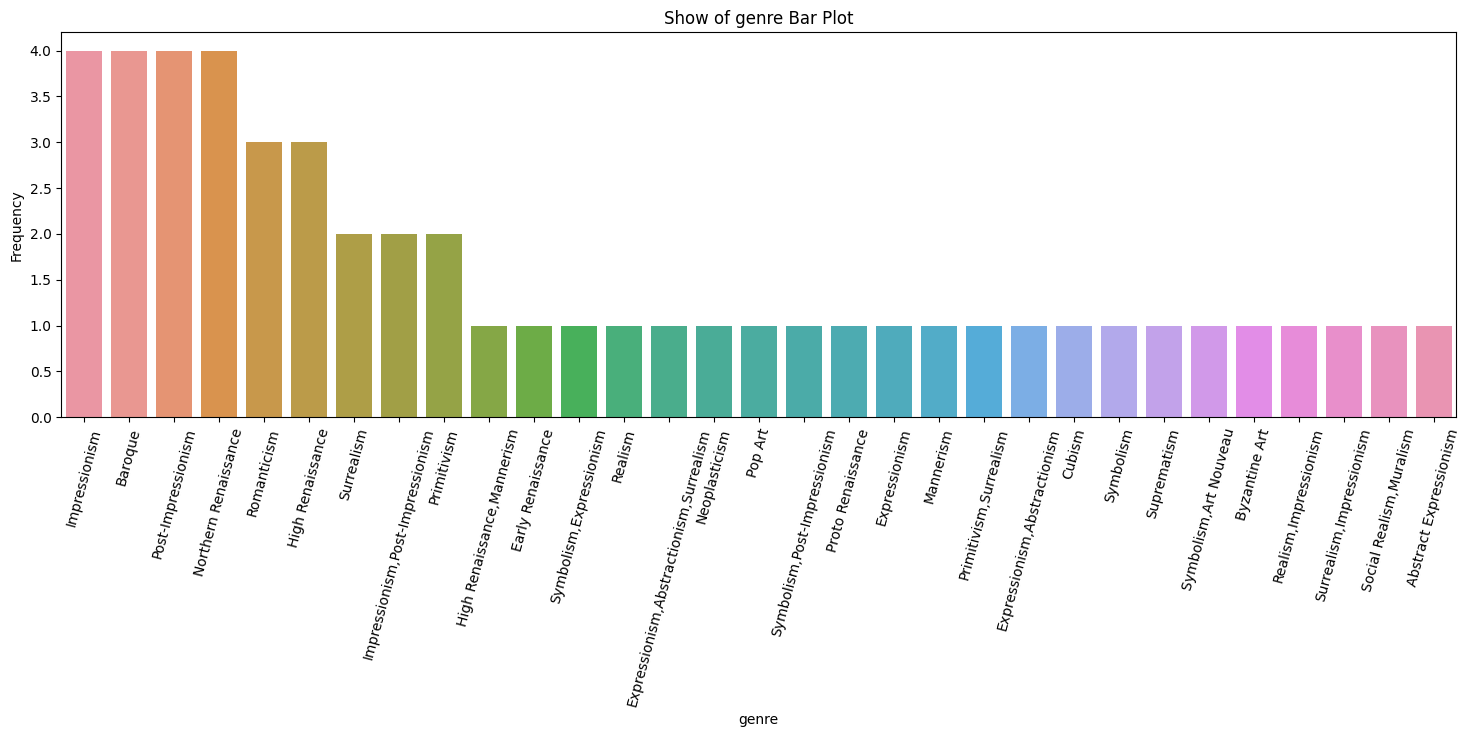

In [12]:
plt.figure(figsize=(18,5))
sns.barplot(x=df['genre'].value_counts().index,
              y=df['genre'].value_counts().values)
plt.xlabel('genre')
plt.xticks(rotation=75)
plt.ylabel('Frequency')
plt.title('Show of genre Bar Plot')
plt.show()

In [16]:
images_dir = './Data/resized'
artists_dirs = list(set([" ".join(filename.split("_")[:-1]) for filename in os.listdir(images_dir)])) #get all names from /resized/resized
n_classes = len(artists_dirs)
print(artists_dirs)

['Andrei Rublev', 'Joan Miro', 'Rembrandt', 'Henri de Toulouse-Lautrec', 'Giotto di Bondone', 'Edvard Munch', 'Caravaggio', 'Raphael', 'Amedeo Modigliani', 'Salvador Dali', 'Hieronymus Bosch', 'Edouard Manet', 'Camille Pissarro', 'Kazimir Malevich', 'Jackson Pollock', 'Claude Monet', 'Marc Chagall', 'Diego Velazquez', 'Alfred Sisley', 'Titian', 'El Greco', 'Francisco Goya', 'Edgar Degas', 'Paul Gauguin', 'Henri Matisse', 'Paul Cezanne', 'Gustav Klimt', 'Pierre-Auguste Renoir', 'Albrecht Dürer', 'Peter Paul Rubens', 'Leonardo da Vinci', 'Sandro Botticelli', 'Albrecht Du╠êrer', 'Pieter Bruegel', 'Vasiliy Kandinskiy', 'Piet Mondrian', 'Vincent van Gogh', 'Paul Klee', 'Mikhail Vrubel', 'Diego Rivera', 'Georges Seurat', 'Andy Warhol', 'Eugene Delacroix', 'Henri Rousseau', 'Jan van Eyck', 'Gustave Courbet', 'Rene Magritte', 'Michelangelo', 'William Turner', 'Pablo Picasso', 'Frida Kahlo']


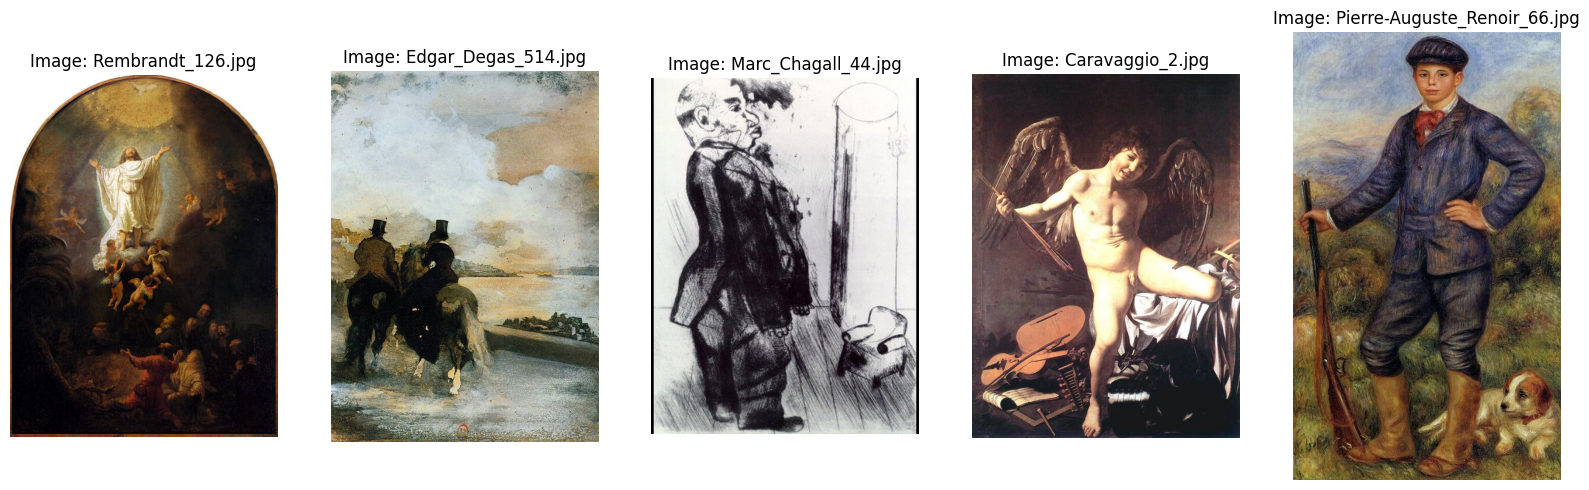

In [24]:
fig, axes = plt.subplots(1, 5, figsize=(20,10))

for i in range(5):
    random_image = random.choice(os.listdir(os.path.join(images_dir)))
    random_image_file = os.path.join(images_dir, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Image: " + random_image)
    axes[i].axis('off')

plt.show()

# Data Augmentation

In [28]:
# Create a DataFrame to store filename and artist mapping
file_artist_mapping = []

for filename in os.listdir(images_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        artist_name = " ".join(filename.split("_")[:-1])
        file_artist_mapping.append({'filename': filename, 'artist': artist_name})

df = pd.DataFrame(file_artist_mapping)

# Get unique artist names
artists = df['artist'].unique()
n_classes = len(artists)

# Define image size and other parameters
img_size = (128, 128)
batch_size = 32

# Create a data generator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Create data generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=images_dir,
    x_col='filename',
    y_col='artist',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=images_dir,
    x_col='filename',
    y_col='artist',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Build a simple CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(n_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)


Found 6947 validated image filenames belonging to 51 classes.
Found 1736 validated image filenames belonging to 51 classes.
Epoch 1/10


2023-12-03 07:06:37.300959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


218/218 [==============================] - 25s 106ms/step - loss: 3.5853 - accuracy: 0.1234 - val_loss: 3.2745 - val_accuracy: 0.1619
Epoch 2/10
218/218 [==============================] - 23s 108ms/step - loss: 3.3199 - accuracy: 0.1784 - val_loss: 3.0696 - val_accuracy: 0.2235
Epoch 3/10
218/218 [==============================] - 24s 110ms/step - loss: 3.2040 - accuracy: 0.2048 - val_loss: 3.1358 - val_accuracy: 0.1935
Epoch 4/10
218/218 [==============================] - 23s 107ms/step - loss: 3.1682 - accuracy: 0.2202 - val_loss: 2.9158 - val_accuracy: 0.2414
Epoch 5/10
218/218 [==============================] - 23s 105ms/step - loss: 3.1230 - accuracy: 0.2368 - val_loss: 2.9785 - val_accuracy: 0.2414
Epoch 6/10
218/218 [==============================] - 23s 107ms/step - loss: 3.0810 - accuracy: 0.2580 - val_loss: 2.8904 - val_accuracy: 0.2932
Epoch 7/10
218/218 [==============================] - 24s 107ms/step - loss: 3.1073 - accuracy: 0.2571 - val_loss: 2.9345 - val_accuracy: 0.2